In [658]:
import pandas as pd

paysim_df=pd.read_csv('./../testdata/test.csv')

In [659]:
paysim_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [660]:
paysim_df_reduced=paysim_df.drop(columns=['nameDest','nameOrig'])
paysim_df_reduced.head()
    

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [661]:
paysim_df_reduced.shape


(49999, 9)

In [662]:
paysim_df_reduced['type'].value_counts()

PAYMENT     21911
CASH_OUT    13756
CASH_IN      8992
TRANSFER     4700
DEBIT         640
Name: type, dtype: int64

In [663]:
types_of_payments = ["CASH_OUT", "PAYMENT", "CASH_IN", "TRANSFER", "DEBIT"]

def get_payment_dict(payment_list):
    rt = {}
    for idx, payment in enumerate(payment_list):
        rt[payment] = idx
    return rt

payment_dict = get_payment_dict(types_of_payments)

print(payment_dict)



{'CASH_OUT': 0, 'PAYMENT': 1, 'CASH_IN': 2, 'TRANSFER': 3, 'DEBIT': 4}


In [664]:
def limit_by_payment_type(types_of_payments, df):
    return df[ df["type"].isin(types_of_payments)]
    
reduced_df_new = limit_by_payment_type(types_of_payments, paysim_df_reduced)
reduced_df_new.head()




,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


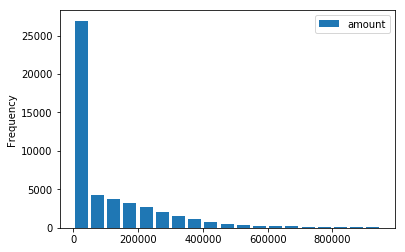

In [665]:
def replace_type_with_id(df, payment_dict):
    
    df["typeMap"] = [0 for i in range(df.shape[0])]
    
    for idx, row in df.iterrows():
        c = row["type"]
        c_id = payment_dict[c]
        df.at[idx, "typeMap"] = c_id        
    return df
    
hot_encoded_df = replace_type_with_id(reduced_df_new, payment_dict)
final_df = hot_encoded_df.drop(['type'], axis=1)

bins = range(0, 1000000, 50000)
labels = range(0, 950000, 50000)
final_df['binned'] = pd.cut(final_df['amount'], bins=bins, labels=labels)

final_df[['amount']].plot(kind='hist',bins=bins,rwidth=0.8)

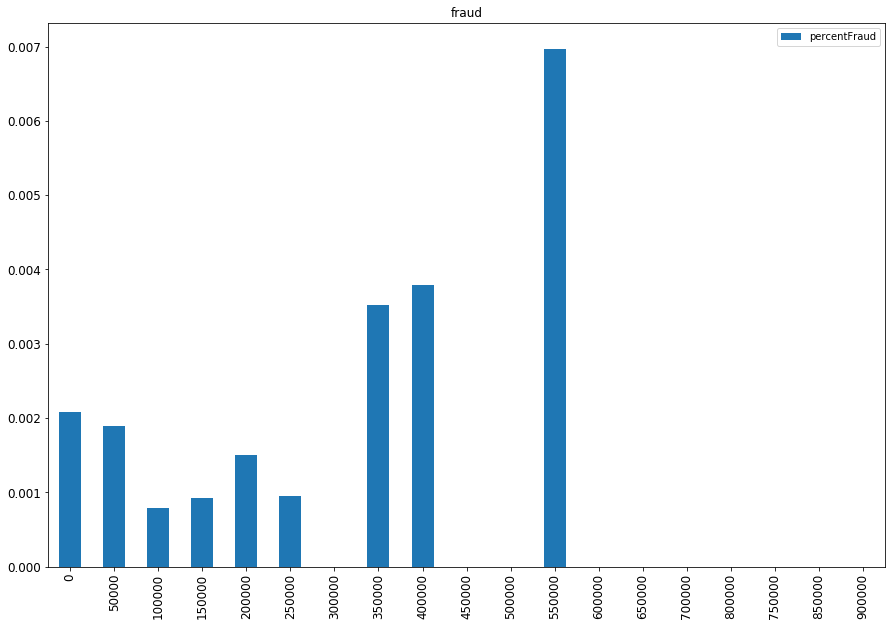

In [666]:
result = final_df['binned'].value_counts().to_frame('totalTx')
result['bin'] = result.index

fraud = final_df.loc[final_df['isFraud'] == 0].groupby(['binned']).size().to_frame('nonfraud')
result = result.join(fraud, lsuffix='', rsuffix='', sort=False)
result['percentFraud'] = (result['totalTx'] - result['nonfraud'])/result['totalTx']

result[['bin','percentFraud']].plot(kind='bar', title ="fraud", figsize=(15, 10), legend=True, fontsize=12)

